# Implementation of K-Means Clustering on NSL-KDD Dataset
Using Method Described in *"K-Means Clustering Approach to Analyze
NSL-KDD Intrusion Detection Dataset"* found [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.413.589&rep=rep1&type=pdf).

Uses scikit-learn k-means learner to classify [NSL-KDD dataset](http://www.unb.ca/cic/research/datasets/nsl.html) and analyze results.

In [1]:
%matplotlib notebook

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale

## Data Loading
Define a data loading function, since categorical columns are converted into binary columns we need to save the order.

In [2]:
def load_data(file_path, cols=None):
    COL_NAMES = ["duration", "protocol_type", "service", "flag", "src_bytes",
                "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]

    data = pd.read_csv(file_path, names=COL_NAMES, index_col=False)
    # Shuffle data
    data = data.sample(frac=1).reset_index(drop=True)
    NOM_IND = [1, 2, 3]
    BIN_IND = [6, 11, 13, 14, 20, 21]
    # Need to find the numerical columns for normalization
    NUM_IND = list(set(range(40)).difference(NOM_IND).difference(BIN_IND))

    # Scale all numerical data to [0-1]
    data.iloc[:, NUM_IND] = minmax_scale(data.iloc[:, NUM_IND])
    labels = data['labels']
    # Binary labeling
    del data['labels']
    data = pd.get_dummies(data)
    if cols is None:
        cols = data.columns
    else:
        map_data = pd.DataFrame(columns=cols)
        map_data = map_data.append(data)
        data = map_data.fillna(0)
        data = data[cols]
    return [data, labels, cols]

## K-Means Evaluation
Now defining an evaluation function that uses the model to cluster rows and then associates each cluster with either "normal" or "anomaly" and calculates the accuracy.

In [3]:
def get_results(data, labels, clf):
    preds = clf.predict(data)
    ans = pd.DataFrame({'label':labels.values, 'kmean':preds})
    return ans

def evaluate_kmeans(data, labels, clf=None):
    if clf is None:
        clf = KMeans(n_clusters=4,init='random').fit(data)
    ans = get_results(data, labels, clf)
    ans = ans.groupby(['kmean', 'label']).size()
    print(ans)

    # Get the larger number from each cluster
    correct = sum([anom if anom > norm else norm for anom, norm in zip(ans[::2],ans[1::2])])
    print("Total accuracy: {0:.1%}".format(correct/sum(ans)))
    return clf

## Loading the training data
The training data is loaded from file, categorical columns are converted into binary columns and numerical columns are scaled to [0-1] values.

In [4]:
train_data, train_labels, cols = load_data('data/KDDTrain+.csv')
train_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.269041,2.183390e-06,0.000036,0,0.0,0.0,0.0,0.0,1,0.000267,...,0,0,0,0,0,0,0,0,1,0
1,0.000000,0.000000e+00,0.000000,0,0.0,0.0,0.0,0.0,0,0.000000,...,1,0,0,0,0,0,0,0,0,0
2,0.000000,0.000000e+00,0.000000,0,0.0,0.0,0.0,0.0,0,0.000000,...,0,0,0,0,1,0,0,0,0,0
3,0.000000,5.797253e-09,0.000000,0,0.0,0.0,0.0,0.0,0,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,0.000000,7.478457e-07,0.000000,0,0.0,0.0,0.0,0.0,0,0.000000,...,0,0,0,0,0,0,0,0,1,0


## Training
Now training the model and checking the accuracy on the training set:

In [5]:
bin_train_labels = train_labels.apply(lambda x: x if x =='normal' else 'anomaly')
clf = evaluate_kmeans(train_data, bin_train_labels)

kmean  label  
0      anomaly     9686
       normal     16087
1      anomaly    34847
       normal       163
2      anomaly    12137
       normal      2959
3      anomaly     1960
       normal     48134
dtype: int64
Total accuracy: 88.3%


## Test Set
---
Loading the test data set, passing the columns will map the test set to match the training columns

In [6]:
test_data, test_labels, cols = load_data('data/KDDTest+.csv', cols)
test_data.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
1,0.0,0.000005,0.000215,0,0.0,0.0,0.0,0.0,1,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.000000,0.000009,0,0.0,0.0,0.0,0.0,0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,0,1,0,0,0,0,0


Now to cluster the test data:

In [7]:
bin_test_labels = test_labels.apply(lambda x: x if x =='normal' else 'anomaly')
evaluate_kmeans(test_data, bin_test_labels, clf)

kmean  label  
0      anomaly    2741
       normal     2265
1      anomaly    2259
       normal        6
2      anomaly    4809
       normal       82
3      anomaly    3024
       normal     7357
dtype: int64
Total accuracy: 76.1%


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Observations

### Graph of Output

<IPython.core.display.Javascript object>


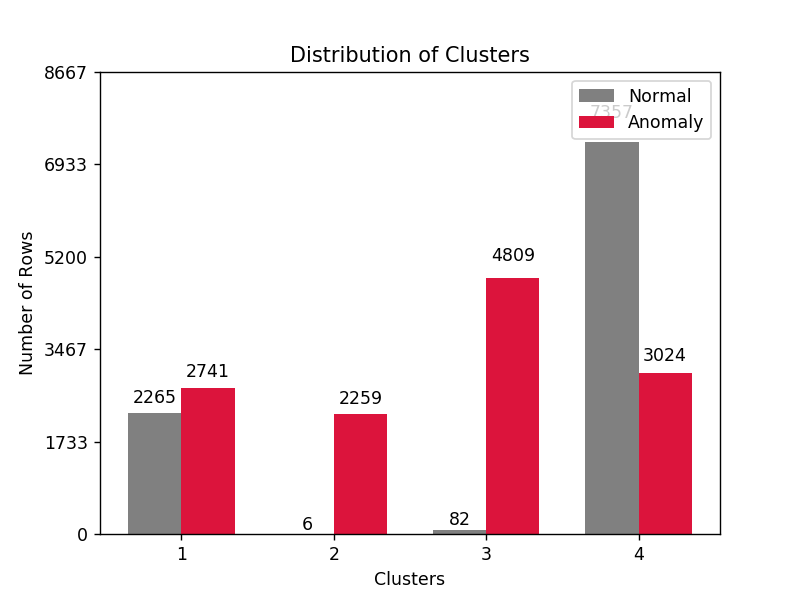

In [8]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.arange(4)
width = .35
ans = get_results(test_data, bin_test_labels, clf)
normal = []
anom = []
bin_ans = ans.groupby(['kmean', 'label']).size()
roof = round(bin_ans.max(), -2) + 3000
for i in range(0,4):
    normal.append(bin_ans[i]['normal'])
    anom.append(bin_ans[i]['anomaly'])
fig, ax = plt.subplots()
rects1 = ax.bar(ind, normal, width, color='grey')
rects2 = ax.bar(ind + width, anom, width, color='crimson')
ax.set_ylabel('Number of Rows')
ax.set_title('Distribution of Clusters')
ax.set_yticks(np.arange(roof, step=roof/6))
ax.set_xlabel('Clusters')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1', '2', '3', '4'))
ax.legend((rects1[0], rects2[0]), ('Normal', 'Anomaly'))

def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects1, ax)
autolabel(rects2, ax)

## Evaluation of Accuracy on each attack

In [9]:
ATTACKS = {
    'normal': 'normal',

    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',

    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',

    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',

    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}


clusters = ['normal' if norm > anom else 'anom' for anom, norm in zip(bin_ans[::2], bin_ans[1::2])]
categ_ans = ans
test_categ_labels = test_labels.apply(lambda x: ATTACKS[x])
categ_ans['label'] = test_categ_labels
categ_ans['kmean'] = categ_ans['kmean'].apply(lambda x: clusters[x])
categ_ans = categ_ans[categ_ans['label'] != 'normal']

categ_ans.groupby(['kmean', 'label']).size()

kmean   label
anom    DoS      5995
        Probe    2418
        R2L      1250
        U2R       146
normal  DoS      1463
        Probe       3
        R2L      1504
        U2R        54
dtype: int64

In [10]:
for label in categ_ans.label.unique():
    print(label)
    total = sum(categ_ans['label']==label)
    print('Total rows: {}'.format(total))
    correct = sum(categ_ans[categ_ans['label']==label]['kmean'] == 'anom')
    print('Percent correctly classified: {:.0%}\n'.format(correct/total))

DoS
Total rows: 7458
Percent correctly classified: 80%

Probe
Total rows: 2421
Percent correctly classified: 100%

R2L
Total rows: 2754
Percent correctly classified: 45%

U2R
Total rows: 200
Percent correctly classified: 73%

